In [ ]:
# clone repository to access files
!git clone https://github.com/hella-innoLab/3PM_notebook.git

# Three-Phase Method
From David Geisler-Moroder: *BSDF generation and use in annual, matrix-based daylight simulations with Radiance*, [RADIANCE workshop 2019](https://www.radiance-online.org/community/workshops/2019-new-york-ny) and from [ThreePhaseMethod Tutorial](https://www.radiance-online.org/learning/tutorials/Tutorial-ThreePhaseMethod.pdf) of Andy McNeil

![blabla](Images/ThreePhaseMethodOverview.png) 

i = VTDs or\
I = VTDS

| Variable | Definition | Common file extensions | 
| -------- | -------- | -------- | 
| I   | matrix containing time series of illuminance or luminance result   | .dat, .ill |
| i   | point in time illuminance or luminance result | |
| V   | view matrix, relating outgoing directions on window to desired results at interior   | .vmx  |
| T   | transmission matrix, relating incident window directions to exiting directions (BSDF)   | .xml  |
| D   | daylight matrix, relating sky patches to incident directions on window   | .dmx  |
| s   | sky vector, assigning luminance values to patches representing sky directions   | .skv  |
| S   |  sky matrix, a collection of sky vectors | .smx  |

### Install and load necessary packages
`pyradiance`: https://github.com/hella-innoLab/pyradiance from https://github.com/LBNL-ETA/pyradiance contains python executable functions of the RADIANCE code collection

In [ ]:
pip install pyradiance

In [50]:
import os # provides functions for interacting with the operating system
import pyradiance as pr 
import subprocess as sp # running external command
import pandas as pd # data analysis and manipulation tool
import matplotlib.pyplot as plt # library for creating static, animated, and interactive visualizations
import numpy as np # scientific computing
from pyradiance.anci import BINPATH
from pathlib import Path

## View matrix

![test](Images/3PM_VMX.png)

![test](Images/VMX_method.png)

[Text(0.5, 0, 'x (m)'), Text(0.5, 0.5, 'y (m)'), Text(0.5, 0, 'height (m)')]

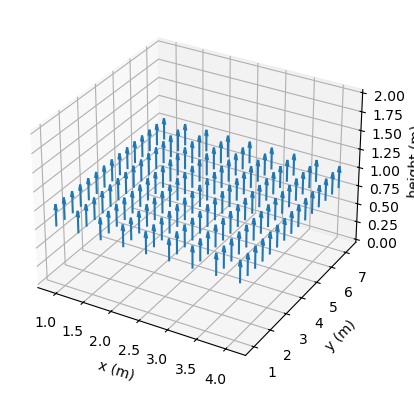

In [51]:
'''
here, the view matrix is calculated for a pre-defined set of points in the room
each point is defined by its location (x,y,z) and view direction (vx,vy,vz)
e.g., these point are the locations of illuminance sensors
''' 
files_path = Path(r"3PM_notebook/files")
receiver_file_path = Path(f"{files_path}/pts/tutorial_workplane.pts")

receiver_points = pd.read_csv(receiver_file_path, header=None, delim_whitespace=True)

# plot of the points
x, y, z = receiver_points[0].values, receiver_points[1].values, receiver_points[2].values
vx, vy, vz = receiver_points[3].values, receiver_points[4].values, receiver_points[5].values

ax = plt.figure().add_subplot(projection='3d')

ax.quiver(x, y, z, vx, vy, vz, length=0.3) #quiver length 0.3 m 
ax.set(zlim = [0,2])
ax.set(xlabel = "x (m)", ylabel = "y (m)", zlabel = "height (m)")

In [53]:
# get number of available CPUs in the system
nprocs = os.cpu_count()

# calculate the view matrix from the window to a illuminance sensor
sender_file_path = Path(f"{files_path}/scene/tutorial_window_vmx_glow.rad")
scene_file_path = Path(f"{files_path}/scene/tutorial_room_3pm.rad")
vmx_file_path = Path(f"{files_path}/matrices/tutorial_room_3pm_sensors_temp.vmx")


rcopts = f"-V- -n {nprocs-2} -w- -I+ -ab 5 -ad 65536 -lw 1.0e-6 -faa"
cmd = f"{BINPATH}/rfluxmtx {rcopts} < {receiver_file_path} - {sender_file_path} {scene_file_path} > {vmx_file_path}"

os.system(cmd)

# TODO: calculate with pyradiance 
#params = ["-V-","-n",f"{nprocs-2}","-w-","-I+","-ab","5","-ad","65536","-lw","1.0e-6","-faa"]
#temp = pr.rfluxmtx(receiver=receiver_file_path, surface=sender_file_path, params=params, scene=[scene_file_path])

print(f"view matrix stored in {vmx_file_path}")

view matrix stored in files/matrices/tutorial_room_3pm_sensors_temp.vmx


## BSDF

![test](Images/3PM_BSDF.png)

![test](Images/BSDF_method.png)


In [54]:
# pre calculated using genBSDF
bsdf_file_path = Path(f"{files_path}/BSDF/blinds_20deg_Klems.xml")

## Daylight matrix

![test](Images/3PM_DMX.png)

![test](Images/DMX_method.png)

In [55]:
sky_subdiv = 4

window_file_path = Path(f"{files_path}/scene/tutorial_window_dmx_dummy.rad")
glow1_rein_file_path = Path(f"{files_path}/misc/sky_glow1_rein{sky_subdiv}.rad")
room_mat_file_path = Path(f"{files_path}/mat/tutorial_room.mat")
room_file_path = Path(f"{files_path}/scene/tutorial_room.rad")
dmx_file_path = Path(f"{files_path}/matrices/tutorial_room_3pm_rein{sky_subdiv}.dmx")

#TODO use pyradiance or subprocess
rcopts = f"-V- -n ${nprocs} -w- -ab 3 -ad 1024 -lw 1.06e-6 -faa"
cmd = f"{BINPATH}/rfluxmtx {rcopts} {window_file_path} {glow1_rein_file_path} {room_mat_file_path} {room_file_path} > {dmx_file_path}"

os.system(cmd)

print(f"daylight matrix stored in {dmx_file_path}")

daylight matrix stored in files/matrices/tutorial_room_3pm_rein4.dmx


## Sky distribution

![test](Images/3PM_SKY.png)

Here: time series

In [56]:
# convert epw file to wea file 
# extract normal direct radiation and diffuse horizontal radiation from epw file
def epw2wea(epw_file, file_out):
    epw_data = pd.read_csv(epw_file_path, header=None, skiprows=8)
    
    with open(epw_file,"r") as file:
        line_temp = file.readline()
    line_split = line_temp.split(",")
    
    month = epw_data[1].values
    day = epw_data[2].values
    hour = epw_data[3].values
    dir_nor_rad = epw_data[14].values
    diff_hor_rad = epw_data[15].values
    
    site_elevation = line_split[-1].split('\n')[0]
    #TODO: timezone is wrong
    time_zone = 70-float(line_split[8])
    
    header = ""
    header += f"place {line_split[1]}_{line_split[3]}\n"
    header += f"latitude {line_split[6]}\n"
    header += f"longitude {-(float(line_split[7]))}\n"
    header += f"time_zone {time_zone}\n" 
    header += f"site_elevation {site_elevation}\n"
    header += f"weather_data_file_units 1\n"

    with open(file_out, 'w') as file:
        file.write(header)
        for m, d, h, dnr, dhr in zip(month, day, hour, dir_nor_rad, diff_hor_rad):
            file.write(f'{m} {d} {h-0.5} {dnr} {dhr}\n')

In [64]:
epw_file_path = Path(f"{files_path}/weather/USA_NY_New.York-Central.Park.725033_TMY3.epw")
wea_file_path = Path(f"{files_path}/weather/NY_sky.wea")
wea_selection_file_path = Path(f"{files_path}/weather/NY_sky_day01.wea")
smx_file_path = Path(f"{files_path}/weather/NY_sky_day01.smx")

epw2wea(epw_file_path, wea_file_path)

# select only first day to show...
lines_n = 30
with open(wea_file_path, "r") as file_in , open(wea_selection_file_path, 'w') as file_out:
    for i in range(lines_n):
        line = next(file_in)
        file_out.write(line)
        
#gendaymtx - generate an annual Perez sky matrix from a weather tape
cmd = f"{BINPATH}/gendaymtx -m {sky_subdiv} {wea_selection_file_path} > {smx_file_path}"

os.system(cmd)


0

## Results

![test](Images/3PM_result.png)

![test](Images/result.png)

In [65]:
var="blinds_20deg"
weather="NY_sky_day01"

result_file_path = Path(f"{files_path}/result/{var}_{weather}_3pm_test.dat")

# I= VTDS = (.vmx)*(.bsdf)*(.dmx)*(.smx)
cmd = f"{BINPATH}/dctimestep {vmx_file_path} {bsdf_file_path} {dmx_file_path} {smx_file_path} > {result_file_path}"

os.system(cmd)


0

In [66]:
# calculate illuminance for sensors
ill_file_path = Path(f"{files_path}/result/{var}_{weather}_3pm_test.ill")

cmd = f"{BINPATH}/rmtxop -fa -c 47.448 119.951 11.601 -t {result_file_path} > {ill_file_path}"

os.system(cmd)



0

In [76]:
# plot illuminance time series along the room
data = pd.read_csv(ill_file_path, header=None, delim_whitespace=True, skiprows=11)

#get center y coor
y_corr = np.unique(y)
y_center = y_corr[int(y_corr.size/2)]
print(y_center)
rp_ind = np.where(y.flatten() == y_center)

data_temp = data[:, rp_ind[0]]

fig = plt.figure()
ax = fig.add_axes([0.15,0.15,.7,.7])

cax = ax.contourf(data_temp.T, cmap = 'afmhot')
ax.set(xlabel="UTC (hour)", ylabel="x (m)")
clb = fig.colorbar(cax)
clb.ax.set_title('illuminance (lx)')




4.1


InvalidIndexError: (slice(None, None, None), array([  7,  22,  37,  52,  67,  82,  97, 112, 127]))